In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from utils import FocalLoss

In [3]:
import fastai
from fastai.vision import *
import pretrainedmodels

In [4]:
from imbalanced_sampler import ImbalancedDatasetSampler

In [5]:
path = Path('.')

In [6]:
train = path/'train_dehaze/'
test =  path/'leaderboard_test_data_dehaze/'
holdout = path/'leaderboard_holdout_data_dehaze/'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [7]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [8]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [9]:
df.head()

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [10]:
(df.has_oilpalm==1).sum()

942

In [11]:
from fastai.torch_core import flatten_model

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [12]:
def get_data(df, size=128, bs=64, pct=0.2, seed=2019):
    data = (ImageItemList.from_df(df, path, folder=train)
           .random_split_by_pct(pct, seed=seed)
           .label_from_df('has_oilpalm')
           .add_test(test_names+holdout_names)
           .transform(get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), size=size))
    
    test_ds = data.test
    train_ds, val_ds = data.train, data.valid
    datasets = [train_ds,val_ds, test_ds]
    sampler = ImbalancedDatasetSampler(datasets[0], func=np.log)
    train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
    val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
    test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)

    return ImageDataBunch(train_dl=train_dl, valid_dl=val_dl, test_dl=test_dl).normalize(imagenet_stats)

In [13]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

def get_learner(data, mixup=True, fp16=True):
    learn = create_cnn(data, 
                       models.densenet121,
                       pretrained=True,
                       loss_func=FocalLoss(gamma=2),
                       metrics=[accuracy])
    if mixup: learn.mixup()
    if fp16: return learn.to_fp16()
    else: return learn

In [14]:
data = get_data(df, 256, 64)

In [15]:
learn = get_learner(data, mixup=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [16]:
get_groups(nn.Sequential(*learn.model[0][0], *learn.model[1]), learn.layer_groups)

Group 1: ['Conv2d', 'BatchNorm2d', 'ReLU', 'MaxPool2d', '_DenseBlock', '_Transition', '_DenseBlock']
Group 2: ['_Transition', '_DenseBlock', '_Transition', '_DenseBlock', 'BatchNorm2d']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear']


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03


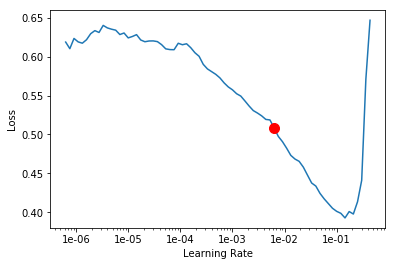

In [24]:
learn.lr_find(); learn.recorder.plot()

In [18]:
lr = 1e-2

# 256

In [19]:
learn.fit_one_cycle(6, lr)
learn.save('dn_256')

epoch,train_loss,valid_loss,accuracy
1,0.064178,0.031692,0.980643
2,0.049780,0.018058,0.985892
3,0.040353,0.018981,0.978018
4,0.037056,0.012366,0.988845
5,0.034630,0.010884,0.991142
6,0.031774,0.012663,0.991470


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


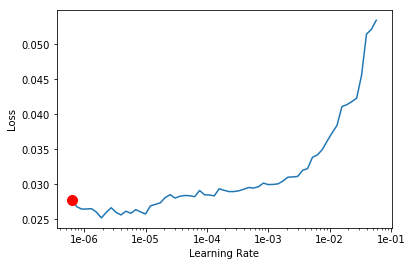

In [20]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [21]:
learn.fit_one_cycle(6, slice(1e-6,1e-5))
learn.save('dn_256u')

epoch,train_loss,valid_loss,accuracy
1,0.032554,0.012462,0.991470
2,0.032724,0.012813,0.991142
3,0.032453,0.012393,0.991470
4,0.031911,0.012279,0.991798
5,0.032912,0.012239,0.991798
6,0.031723,0.012183,0.991798


# Results

In [17]:
learn = get_learner(data, mixup=False)
learn.load('dn_256u');

[(1, 0, 20), (0, 1, 5)]

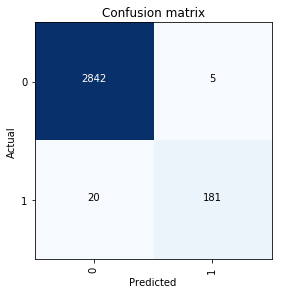

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused()

In [75]:
interp.top_losses(10)

(tensor([1.2399, 1.1326, 1.1027, 0.9937, 0.7246, 0.7118, 0.6689, 0.5742, 0.5042,
         0.4873]),
 tensor([2032,  605, 1184,  276,  699, 2626, 1828, 2943, 1493, 1889]))

In [96]:
p_v,t_v = learn.get_preds()

In [100]:
(p_v[:,1]>0).sum()

tensor(186)

## Sub file

In [124]:
def sigmoid(array):
    return 1/(1+np.exp(-array))

In [25]:
p,t = learn.get_preds(DatasetType.Test)

In [151]:
preds = to_np(p[:,1].sigmoid());preds.shape

(6534,)

In [152]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names], dtype=str); ids[0:3]

array(['img_000022018.jpg', 'img_000042017.jpg', 'img_000052017.jpg'], dtype='<U17')

In [153]:
sub = pd.DataFrame(np.stack([ids, preds], axis=1), columns=df_sample.columns)
sub.has_oilpalm = sub.has_oilpalm.astype(float)
sub.head()

,image_id,has_oilpalm
0,img_000022018.jpg,0.289372
1,img_000042017.jpg,0.445922
2,img_000052017.jpg,0.307982
3,img_000062017.jpg,0.279337
4,img_000062018.jpg,0.331444


In [154]:
sub.dtypes

image_id        object
has_oilpalm    float64
dtype: object

In [155]:
test_filenames = [f.name for f in test_names]
holdout_filenames = [f.name for f in holdout_names]

In [156]:
sub_df = sub.set_index('image_id')

In [157]:
sub_test = sub_df.loc[test_filenames]
sub_holdout = sub_df.loc[holdout_filenames]

In [158]:
sub_test.describe()

,has_oilpalm
count,4356.000000
mean,0.314841
std,0.072443
min,0.001466
25%,0.283360
50%,0.298287
75%,0.318273
max,0.618723


In [159]:
sub_holdout.describe()

,has_oilpalm
count,2178.000000
mean,0.426154
std,0.134113
min,0.029987
25%,0.296272
50%,0.389054
75%,0.564624
max,0.628749


In [160]:
(sub_test.has_oilpalm>0.5).sum()

255

In [161]:
(sub_holdout.has_oilpalm>0.5).sum()

1006

In [162]:
sub.to_csv('sub_resnext_sigmoid.csv', index=False)

In [163]:
sub.head()

,image_id,has_oilpalm
0,img_000022018.jpg,0.289372
1,img_000042017.jpg,0.445922
2,img_000052017.jpg,0.307982
3,img_000062017.jpg,0.279337
4,img_000062018.jpg,0.331444


# Metric Learning

In [175]:
def feature_map(data):
    learn = get_learner(data)
    learn.load('dn_256u');
    learn.model = nn.Sequential(*learn.model[0][0],Flatten())
#     learn.model = nn.Sequential(*learn.model[0][0],*learn.model[1][0:2])
    p,t = learn.get_preds(DatasetType.Train)
    p_t, t_t = learn.get_preds(DatasetType.Test)
    return p, t, p_t, t_t

In [176]:
data_no_valid = get_data(df, 256, 64, 0)

In [177]:
p,t,p_t, t_t = feature_map(data_no_valid )

In [178]:
p.shape

torch.Size([15244, 65536])

In [179]:
len(p)==len(df)

True

In [159]:
def calculate_distance(x,y):
    d = (x-y).abs_()
    return d.sum(dim=1)

In [161]:
%timeit an = calculate_distance(p_t[0,:], p)

69.5 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [157]:
an.shape

torch.Size([15244])

In [180]:
def compute_distances(sample=len(p_t)):
    distances = torch.zeros(sample,len(p))
    for i in progress_bar(range(sample)):
        distances[i,:] = calculate_distance(p_t[i,:], p)
    return distances

In [181]:
d = compute_distances(10)

In [182]:
d[0,:].topk(5, largest=False)

(tensor([33948.4922, 34266.8164, 34600.1562, 34941.8789, 35003.1406]),
 tensor([ 8404, 11762, 12599,  8416,  6092]))

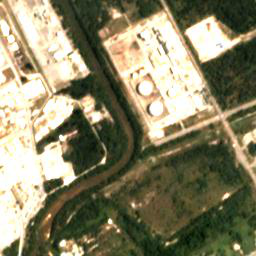

In [183]:
data_no_valid.test_ds[0][0]

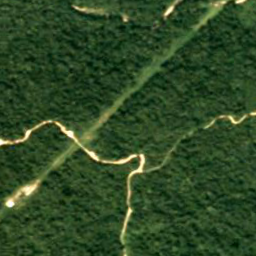

In [185]:
data_no_valid.train_ds[11762][0]